<div>
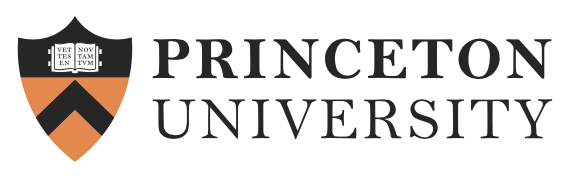
</div>

<div>
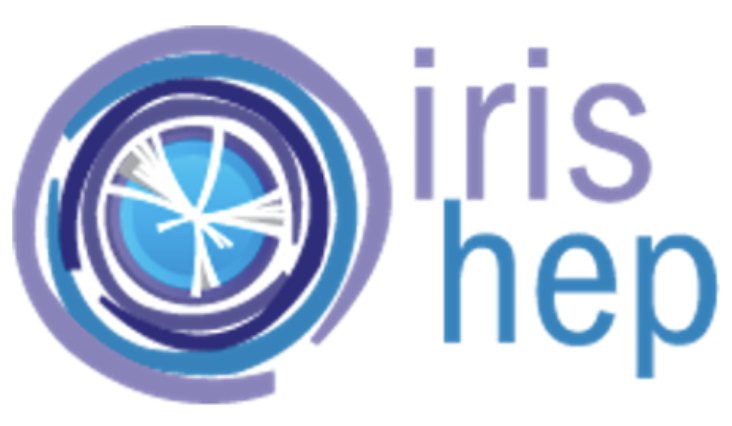
</div>

# Awkward to RDataFrame and back
### Ianna Osborne, Jim Pivarski 
*Princeton University*

[Awkward Array](https://github.com/scikit-hep/awkward) is a library for nested, variable-sized data, including arbitrary-length lists, records, mixed types, and missing data, using NumPy-like idioms. It is a cornerstone of user analyses in Python eco-system.

[RDataFrame](https://root.cern.ch/doc/master/classROOT_1_1RDataFrame.html) - [ROOT](https://root.cern.ch/doc/master/namespaceROOT.html)'s declarative analysis interface that supports many input formats. Awkward Arrays and RDataFrame are two very different ways of performing calculations at scale.

There are numerous benefits of the combining both Python and C++. Physicists can mix analyses using Awkward Arrays, Numba, and ROOT C++ in memory, without saving to disk and without leaving their environment.

<div>
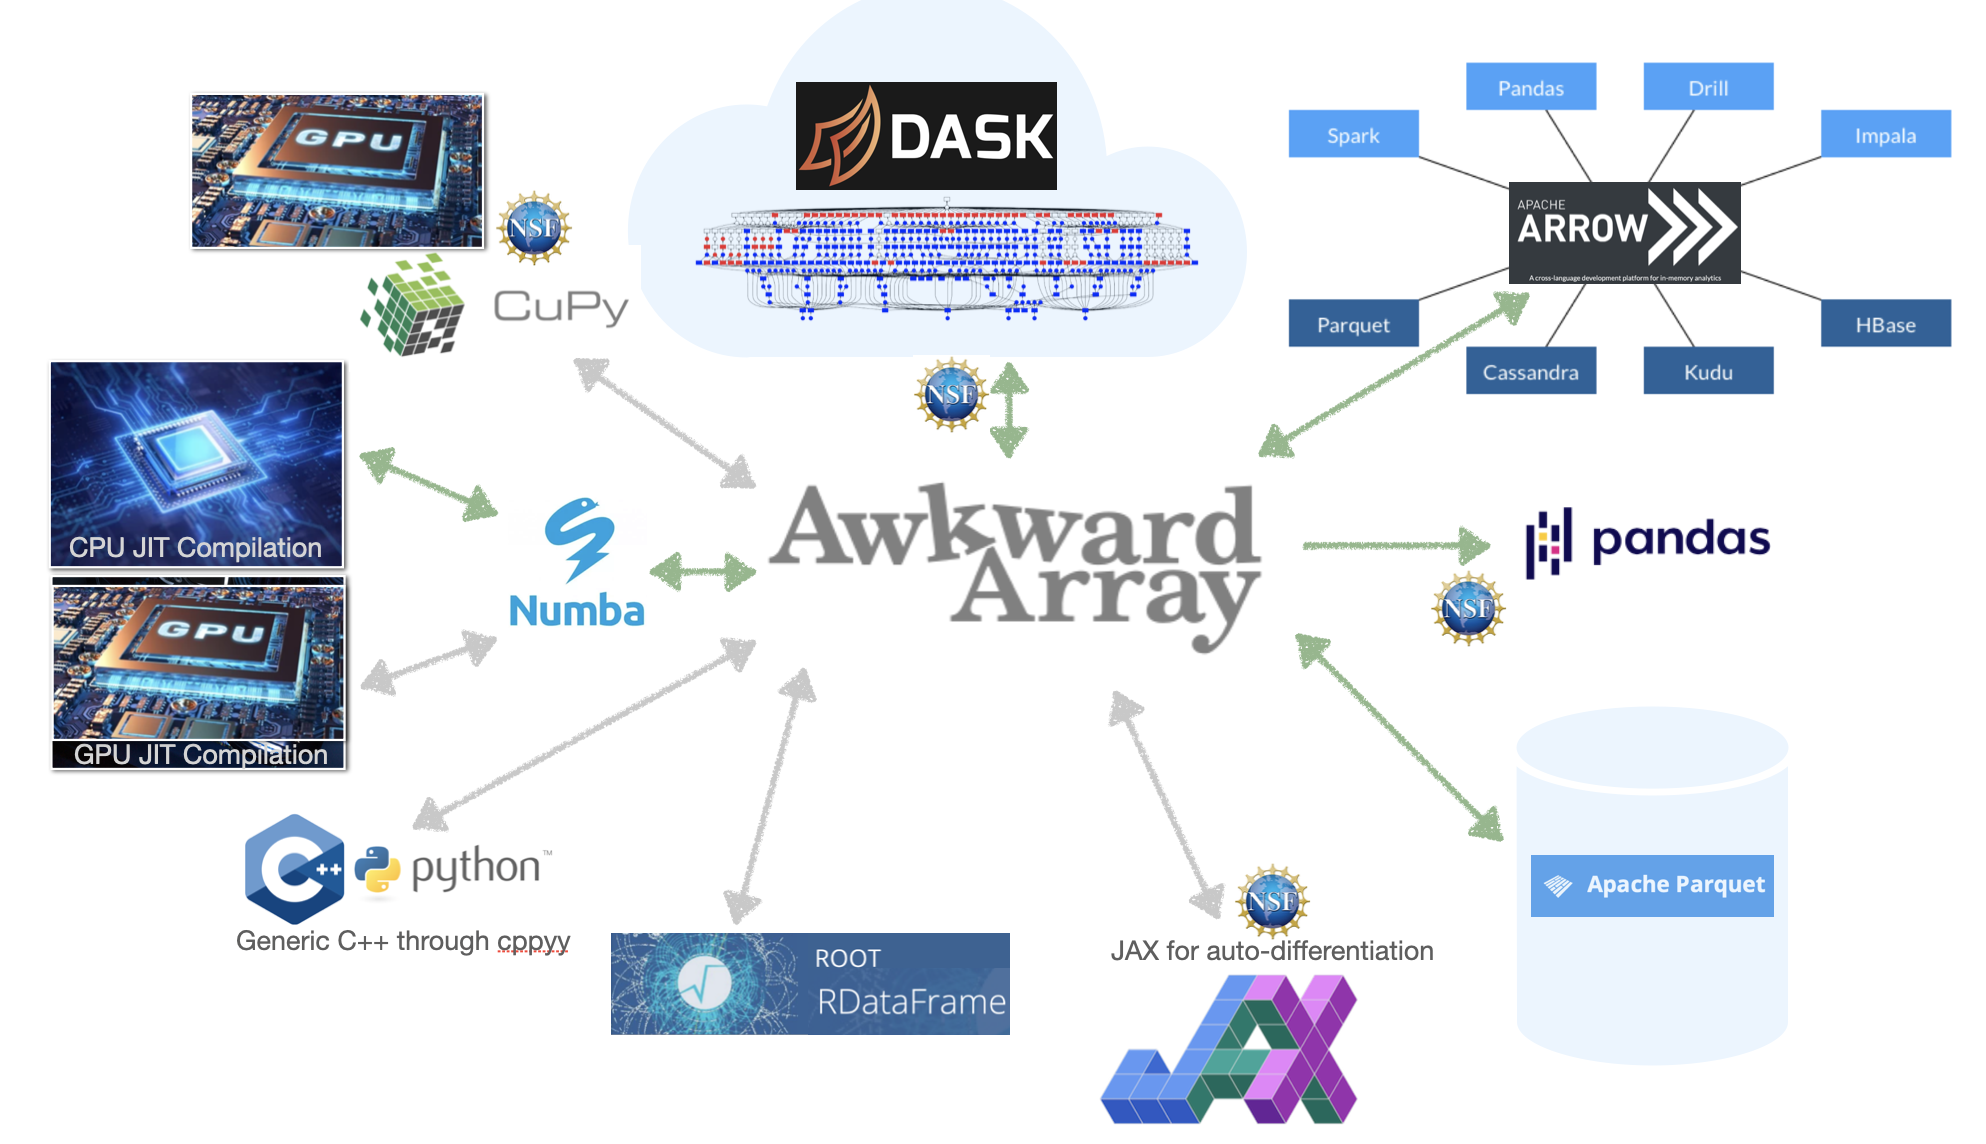
</div>

## From Awkward Arrays to RDataFrame

In [1]:
import awkward._v2 as ak
import ROOT

Welcome to JupyROOT 6.26/02


Let’s start from Awkward Arrays and put them into an RDataFrame. The awkward style `ak.to_rdataframe` function takes a dictionary: a key defines a column name of an Awkward Array that will be placed in the RDataFrame.

In [2]:
array_x = ak.Array(
        [
            {"x": [1.1, 1.2, 1.3]},
            {"x": [2.1, 2.21]},
            {"x": [3.1]},
            {"x": [4.1, 4.2, 4.3, 4.4]},
            {"x": [5.1]},
        ]
    )
array_y = ak.Array([1, 2, 3, 4, 5])
array_z = ak.Array([1.1, 2.2, 3.3, 4.4, 5.5])


df = ak.to_rdataframe({"x": array_x, "y": array_y, "z": array_z})

In [3]:
# Describe the state of the dataframe.
# Note that this operation is not running the event loop.
# Describe returns a DFDescription object, which has e.g. a Print method. See its docs for more information.
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  ULong64_t                       Define
x               awkward::Record_GfeTYM4b2CM     Dataset
y               int64_t                         Dataset
z               double                          Dataset

The `x` column contains an Awkward Array with a made-up `awkward::Record_cKnX5DyNVM` type.

Awkward Arrays are dynamically typed, so in a C++ context, the type name is hashed. In practice, there is no need to know the type. The C++ code should use a placeholder type specifier `auto`. The type of the variable that is being declared will be automatically deduced from its initializer.

In [4]:
df.GetColumnType("x")

'awkward::Record_GfeTYM4b2CM'

In [5]:
df.GetColumnType("y")

'int64_t'

In [6]:
df.GetColumnType("z")

'double'

In [7]:
df = df.Filter("y > 2")

In [8]:
# Note that this operation is not running the event loop.
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  ULong64_t                       Define
x               awkward::Record_GfeTYM4b2CM     Dataset
y               int64_t                         Dataset
z               double                          Dataset

In [9]:
# Trigger the event loop once to retrieve all selected columns.
out = ak.from_rdataframe(
    df,
    columns=("x", "y", "z",),
)

In [10]:
out

<Array [{y: 3, z: 3.3, x: {...}}, ..., {...}] type='3 * {y: int64, z: float...'>

In [11]:
# Check that this operation triggered the event loop once.
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  ULong64_t                       Define
x               awkward::Record_GfeTYM4b2CM     Dataset
y               int64_t                         Dataset
z               double                          Dataset

In [12]:
# Let's check the type of the Awkward Array.
# The initial input Record_* is indexed because of to the filter selection, but it's content not copied.
out.show(type=True)

type: 3 * {
    y: int64,
    z: float64,
    x: {
        x: var * float64
    }
}
[{y: 3, z: 3.3, x: {x: [3.1]}},
 {y: 4, z: 4.4, x: {x: [4.1, ..., 4.4]}},
 {y: 5, z: 5.5, x: {x: [5.1]}}]


In [13]:
# Let's check the filtered entries for "y > 2".
print(out["y"].to_list())
print(out["z"].to_list())
print(out["x"].to_list())

[3, 4, 5]
[3.3, 4.4, 5.5]
[{'x': [3.1]}, {'x': [4.1, 4.2, 4.3, 4.4]}, {'x': [5.1]}]


In [14]:
# Check to make sure we triggered the event loop only once.
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  ULong64_t                       Define
x               awkward::Record_GfeTYM4b2CM     Dataset
y               int64_t                         Dataset
z               double                          Dataset

## From RDataFrame to Awkward Arrays

The *`ak.from_rdataframe`* function converts selected columns to native Awkward Arrays.

The function takes a tuple of strings that are the RDF column names and it recognizes the following column data types:

* Primitive types: `integer`, `float`, `double`, `std::complex<double>`, etc.
* Lists of primitive types and the arbitrary depth nested lists of primitive types: `std::vector<double>`, `RVec<int>`, etc.
* Awkward types: run-time generated types derived from `awkward::ArrayView` or `awkward::RecordView`
  * because Awkward Arrays are immutable no copy required
  


<div>
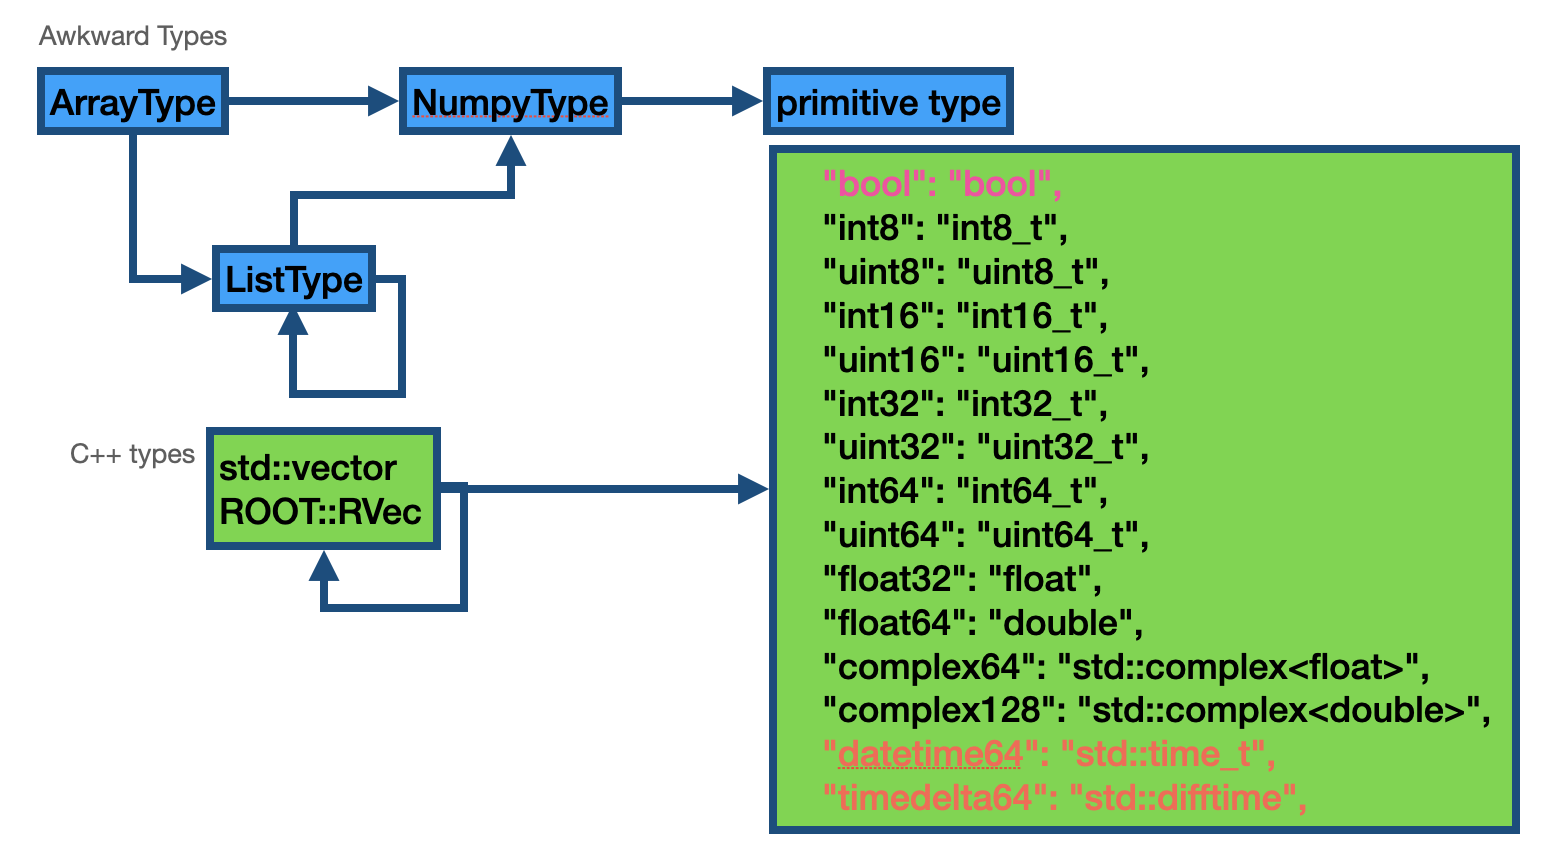
</div>

In [15]:
import awkward._v2 as ak
import matplotlib
import matplotlib.pyplot as plt
import ROOT

In [16]:
# CMS data from CERN Open Data portal: http://opendata.web.cern.ch/record/12341.
#
# DoubleMuParked dataset from 2012 in NanoAOD format reduced on muons
#  Wunsch, Stefan

# Cite as: Wunsch, Stefan; (2019). DoubleMuParked dataset from 2012 in NanoAOD format 
# reduced on muons. CERN Open Data Portal. DOI:10.7483/OPENDATA.CMS.LVG5.QT81

# Dataset Derived CMS CERN-LHC

# Description
# This dataset contains about 60 mio. data events from the CMS detector taken in 2012 
# during Run B and C. The original AOD dataset is converted to the NanoAOD format and 
# reduced to the muon collections. The dataset in the file is called Events and contains 
# columns as described in the table below.
#
# Dataset semantics
# Variable	Type	Description
# nMuon	unsigned int	Number of muons in this event
# Muon_pt	float[nMuon]	Transverse momentum of the muons (stored as an array of size nMuon)
# Muon_eta	float[nMuon]	Pseudorapidity of the muons
# Muon_phi	float[nMuon]	Azimuth of the muons
# Muon_mass	float[nMuon]	Mass of the muons
# Muon_charge	int[nMuon]	Charge of the muons (either 1 or -1)

# Create a dataframe
df = ROOT.RDataFrame('Events', 'Run2012BC_DoubleMuParked_Muons.root')

In [17]:
# Describe the state of the dataframe.
# Note that this operation is not running the event loop.
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            6
Columns from defines        0
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

In [18]:
# Build a small analysis studying the invariant mass of dimuon systems.
# See tutorial df102_NanoAODDimuonAnalysis for more information:
# https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html
df = df.Filter('nMuon == 2')\
       .Filter('Muon_charge[0] != Muon_charge[1]')\
       .Define('Dimuon_mass', 'InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)')\
       .Filter('Dimuon_mass > 70')\
       .Range(1000)

In [19]:
# Trigger the event loop by asking for the mean of the dimuon mass.
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



In [20]:
# Check that this operation triggered the event loop once:
#
# Event loops run             1
#
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

In [21]:
# Convert selected columns to Awkward array.
array = ak.from_rdataframe(
        df,                #     Type                            Origin
        columns=(          #     ----                            ------
            "Dimuon_mass", #     float                           Define
            "Muon_charge", #     ROOT::VecOps::RVec<Int_t>       Dataset
            "Muon_eta",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_mass",   #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_phi",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_pt",     #     ROOT::VecOps::RVec<Float_t>     Dataset
            "nMuon",       #     UInt_t                          Dataset
        ),
    )

In [22]:
array

<Array [{Dimuon_mass: 114, ...}, ..., {...}] type='1000 * {Dimuon_mass: flo...'>

In [23]:
# Check the array type.
array.show(type=True)

type: 1000 * {
    Dimuon_mass: float32,
    Muon_charge: var * int32,
    Muon_eta: var * float32,
    Muon_mass: var * float32,
    Muon_phi: var * float32,
    Muon_pt: var * float32,
    nMuon: uint32
}
[{Dimuon_mass: 114, Muon_charge: [-1, 1], Muon_eta: [...], Muon_mass: ..., ...},
 {Dimuon_mass: 88.3, Muon_charge: [1, -1], Muon_eta: [2.2, ...], ...},
 {Dimuon_mass: 88.3, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 91.3, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 93.6, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 90.9, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 89.2, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 82.3, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 94.6, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 89.2, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 ...,
 {Dimuon_mass: 86.4, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 77.1, Muon_charge: [-1, 1]

In [24]:
# Check that all the columns were retrieved in a single event loop:
#
# Event loops run             2
#
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             2
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

In [39]:
array["Dimuon_mass"]

<Array [114, 88.3, 88.3, 91.3, ..., 89.6, 91.1, 90.1] type='1000 * float32'>

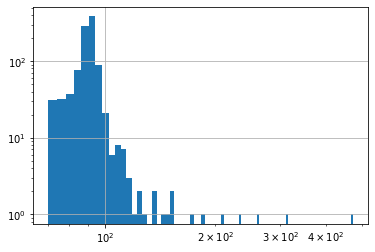

In [35]:
# plot `Dimuon_mass`
plt.hist(array["Dimuon_mass"], bins=100)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

In [29]:
import numpy as np

In [30]:
np.mean(array["Dimuon_mass"])

91.438576

## Large-scale Awkward data roundtrip

In [52]:
# Create a dataframe
df = ROOT.RDataFrame('Events', 'Run2012BC_DoubleMuParked_Muons.root')

In [66]:
array = ak.from_rdataframe(
        df,                #     Type                            Origin
        columns=(          #     ----                            ------
            "Muon_charge", #     ROOT::VecOps::RVec<Int_t>       Dataset
            "Muon_eta",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_mass",   #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_phi",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_pt",     #     ROOT::VecOps::RVec<Float_t>     Dataset
            "nMuon",       #     UInt_t                          Dataset
        ),
    )

In [67]:
array

<Array [{Muon_charge: [...], ...}, ..., {...}] type='61540413 * {Muon_charg...'>

In [68]:
df = ak.to_rdataframe({"Muon_charge": array["Muon_charge"], 
                       "Muon_eta": array["Muon_eta"], 
                       "Muon_mass": array["Muon_mass"],
                       "Muon_phi": array["Muon_phi"],
                       "Muon_pt": array["Muon_pt"],
                       "nMuon": array["nMuon"],
                      })

In [69]:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Muon_charge     ROOT::VecOps::RVec<int32_t>     Dataset
Muon_eta        ROOT::VecOps::RVec<float>       Dataset
Muon_mass       ROOT::VecOps::RVec<float>       Dataset
Muon_phi        ROOT::VecOps::RVec<float>       Dataset
Muon_pt         ROOT::VecOps::RVec<float>       Dataset
awkward_index_  ULong64_t                       Define
nMuon           uint32_t                        Dataset

In [70]:
array.show(type=True)

type: 61540413 * {
    Muon_charge: var * int32,
    Muon_eta: var * float32,
    Muon_mass: var * float32,
    Muon_phi: var * float32,
    Muon_pt: var * float32,
    nMuon: uint32
}
[{Muon_charge: [-1, -1], Muon_eta: [1.07, -0.564], Muon_mass: [...], ...},
 {Muon_charge: [1, -1], Muon_eta: [-0.428, 0.349], Muon_mass: [...], ...},
 {Muon_charge: [1], Muon_eta: [2.21], Muon_mass: [0.106], Muon_phi: ..., ...},
 {Muon_charge: [1, 1, 1, 1], Muon_eta: [-1.59, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, -1, 1, 1], Muon_eta: [-2.17, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1, -1], Muon_eta: [-1.37, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [-0.532, -1], Muon_mass: [...], ...},
 {Muon_charge: [1, -1], Muon_eta: [-0.772, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [0.442, 0.702], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [2.34, 2.35], Muon_mass: [...], ...},
 ...,
 {Muon_charge: [1, -1], Muon_eta: [0.252, 0.275], Muon_ma

In [75]:
df = df.Filter('nMuon == 2')\
       .Filter('Muon_charge[0] != Muon_charge[1]')\
       .Redefine('Dimuon_mass', 'InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)')\
       .Filter('Dimuon_mass > 70')\
       .Range(1000)

In [76]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



Awkward Arrays and RDataFrame provide two very different ways of performing calculations at scale.
By adding the ability to convert between them, users get the best of both.
The Awkward-RDF bridge provides users with more flexibility in mixing different packages and languages in their analysis.
It is a part of Awkward version 2, which is currently a submodule `ak._v2`.
Awkward version 2 will be fully released at the beginning of December 2022. You can see the time line [here](https://github.com/scikit-hep/awkward/wiki).

<div>
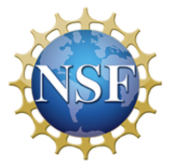
</div>

#### OAC-1836650